In [1]:
# Installation of Spacy
# Need spacy version 2.1.0 for neuralcoref
# use python 3.6 for neuralcoref
#!python -m spacy download en_core_web_sm

In [2]:
import matplotlib.pyplot as plt
import nltk
import re
import spacy
nltk.download('gutenberg')
# benchmark data
# https://spacy.io/usage/facts-figures#benchmarks

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

# Add neural coref to SpaCy's pipe
# https://github.com/huggingface/neuralcoref
import neuralcoref
neuralcoref.add_to_pipe(nlp)

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Bhavya\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [3]:
spacy.__version__

'2.1.0'

In [4]:
book = nltk.corpus.gutenberg.raw('carroll-alice.txt')

doc = nlp(book)

In [5]:
def extract_main_entity(ent):
    res = ""
    for e in ent.ents:
        if e.label_ == "PERSON":
            res = res + e.text + " "
    return res.strip()

In [4]:
#file_name = 'HP - The Philosopher Stone.txt' #
file_name = 'test_chapter.txt'

book = open(file_name, encoding="utf8").read()
# clean text - remove all page headers

book = re.sub(r'\W*Page |.*J.K. Rowling\W*', ' ', book)

#doc = nlp(book)

In [78]:
#for e in doc._.coref_clusters:
#    print(e.main, " -- ",extract_main_entity(e.main))

In [11]:
chars = {}  # stores all uniques characters in the story along with their number of occurences
occ = []  # stores each person entity along with its starting, end index 
for c in doc._.coref_clusters:
    main_ent = extract_main_entity(c.main)
    if len(main_ent)>0:
        #print(str(main_entity), len(c.mentions))
        #main_entity = main_entity.text
        if main_ent not in chars:
            chars[main_ent] = len(c.mentions)
        else:
            chars[main_ent] += len(c.mentions)
        
        for m in c.mentions:
            occ.append((main_ent, m.start_char, m.end_char))

Text(0, 0.5, 'Number of Mentions')

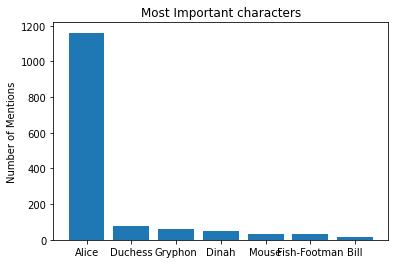

In [12]:
top_chars = [(c, chars[c]) for c in chars]
top_chars.sort(key = lambda x: x[1], reverse=True)
data = top_chars[:7]
x = [t[0] for t in data]
y = [t[1] for t in data]
plt.bar(x, y)
plt.title("Most Important characters")
plt.ylabel("Number of Mentions")

In [12]:
# returns list of positions specific to granualrity 
# for eg. - retruns where chapter starts
# returns list of positions specific to granualrity 
# for eg. - retruns where chapter starts
def delimiter(txt, gran="para"):
    if gran=="para":
        return [m.start() for m in re.finditer('\n\n', txt)]
    elif gran=="sent":
        return [sent[-1].idx for sent in doc.sents]
    elif gran=="CHAPTER":
        return [m.start() for m in re.finditer(gran, txt)]        

In [14]:
occ.sort(key = lambda x: x[1])
occ[:5]

[('Alice', 91, 96),
 ('Alice', 143, 146),
 ('Alice', 351, 358),
 ('Alice', 397, 400),
 ('Alice', 420, 423)]

In [15]:
# stores characters frequency for each chapter/para
delims = delimiter(book, "CHAPTER") #    
res = []
cnt = {}
unit_end = 0
for w,ind,_ in occ:
    if unit_end<len(delims) and ind>delims[unit_end]:
        #print(w, ind)
        res.append(cnt)
        cnt = {}
        unit_end = unit_end + 1
        
    if w not in cnt:
        cnt[w] = 1
    else:
        cnt[w] = cnt[w] + 1
res.append(cnt)

In [16]:
len(res), len(delims)

(13, 12)

In [17]:
# tranforms data
# sotres each char as key and value is the list of frequency for each chapter/para
chars_by_time = {}

for char,_ in top_chars:
        chars_by_time[char] = []

for unit in res:
    for char in chars:
        if char in unit:
            chars_by_time[char].append(unit[char])
        else:
            chars_by_time[char].append(0)

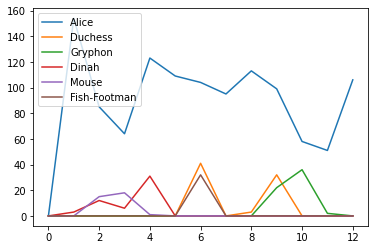

In [18]:
for i, ch in enumerate(chars_by_time):    
    if i>5:  # number of characters (lines) to show
        break
    plt.plot(chars_by_time[ch], label=ch)
plt.legend()

<h3>package into a function</h3>

In [7]:
def extract_main_entity(ent):
    res = ""
    for e in ent.ents:
        if e.label_ == "PERSON":
            res = res + e.text + " "
    return res.strip()

# returns mapping for each token start index to unit index based on granualrity 
# There are 3 possible values for granularity namely, para - paragraph, sent - sentence, CHAPTER - chapter
def delimiter(txt, doc, gran="para"):
    limits = None
    if gran=="para":
        limits = [m.start() for m in re.finditer('\n\n', txt)]
    elif gran=="sent":
        limits = [sent.start_char for sent in doc.sents]
    elif gran=="CHAPTER":
        limits = [m.start() for m in re.finditer(gran, txt)]
    # mapping a start ind of each token to granularity index
    res = {}
    limit_ind = 0
    for e in doc:
        if limit_ind<len(limits) and e.idx>limits[limit_ind]:
            limit_ind += 1
        res[e.idx] = limit_ind
    return res
    
# given some text and level of granularity, returns list of entities along with their index
def timeline(txt, gran="para"):
    doc = nlp(txt)
    mapping = delimiter(txt, doc, gran)
    res = []
    for c in doc._.coref_clusters:
        # we only consider proper nouns like 'ALICE'
        main_ent = extract_main_entity(c.main)
        if len(main_ent)>0:
            #print(str(main_entity), len(c.mentions))
            for ent in c.mentions:
                res.append((main_ent, mapping[ent.start_char]))
    return res

In [69]:
len(timeline(book))

201

In [8]:
# Timeline for long doucments
# given some text and level of granularity, returns list of entities along with their index
def timeline(txt):
    limits = []
    for i, m in enumerate(re.finditer('\n\n', txt)):
        if i>0 and i%10==0:  # consider 10 paras as single entity
            limits.append(m.start())
    limits.append(len(txt))

    st = 0
    res = {}
    for end in limits:
        doc = nlp(txt[st:end])
        for c in doc._.coref_clusters:
            # we only consider proper nouns like 'ALICE'
            main_ent = extract_main_entity(c.main)
                
            if len(main_ent)>0:
                if main_ent not in res:
                    res[main_ent] = []
                #print(str(main_entity), len(c.mentions))
                for ent in c.mentions:
                    #res.append((main_ent, st + ent.start_char))
                    res[main_ent].append((main_ent, st + ent.start_char, st + ent.end_char, ent))
        st = end + 1
    
    r = []
    for k in res:
        r.extend(res[k])
    
    return r

In [9]:
r = timeline(book)
r

[('Historic Annapolis', 114, 132, Historic Annapolis),
 ('Historic Annapolis', 174, 177, her),
 ('Historic Annapolis', 201, 203, it),
 ('Historic Annapolis', 217, 220, her),
 ('Kate Warren', 229, 240, Kate Warren),
 ('Kate Warren', 261, 264, her),
 ('Kate Warren', 351, 354, her),
 ('Kate Warren', 502, 505, her),
 ('Kate Warren', 580, 583, her),
 ('Kate Warren', 599, 602, her),
 ('Kate Warren', 649, 652, She),
 ('Kate Warren', 820, 823, her),
 ('Kate Warren', 874, 877, she),
 ('Kate Warren', 908, 911, her),
 ('Kate Warren', 1039, 1042, She),
 ('Kate Warren', 1192, 1195, she),
 ('Kate Warren', 1212, 1215, she),
 ('Kate Warren', 1255, 1258, her),
 ('Kate Warren', 1308, 1311, she),
 ('Kate Warren', 1329, 1332, she),
 ('Kate Warren', 1429, 1432, her),
 ('Kate Warren', 1560, 1563, she),
 ('Kate Warren', 1636, 1639, she),
 ('Kate Warren', 1882, 1885, She),
 ('Kate Warren', 2254, 2257, her),
 ('Kate Warren', 2294, 2297, her),
 ('Kate Warren', 2370, 2373, her),
 ('Kate Warren', 2407, 2410, her)

In [10]:
# Timeline for long doucments
# given some text and level of granularity, returns list of entities along with their index
def timeline(txt):
    limits = []
    char_ref = {}
    for i, m in enumerate(re.finditer('\n\n', txt)):
        if i>0 and i%10==0:  # consider 10 paras as single entity
            limits.append(m.start())
    limits.append(len(txt))

    st = 0
    res = {}
    for end in limits:
        doc = nlp(txt[st:end])
        for c in doc._.coref_clusters:
            # we only consider proper nouns like 'ALICE'
            main_ent = extract_main_entity(c.main)
                
            if len(main_ent)>0:
                if main_ent not in res:
                    res[main_ent] = []
                #print(str(main_entity), len(c.mentions))
                for ent in c.mentions:
                    #res.append((main_ent, st + ent.start_char))
                    res[main_ent].append((main_ent, st + ent.start_char, st + ent.end_char, ent))
                    char_ref[st + ent.start_char] = main_ent
        st = end + 1
    
    r = []
    for k in res:
        r.extend(res[k])
    
    return r, char_ref

In [11]:
r, ch = timeline(book)

In [12]:
ch

{114: 'Historic Annapolis',
 174: 'Historic Annapolis',
 201: 'Historic Annapolis',
 217: 'Historic Annapolis',
 229: 'Kate Warren',
 261: 'Kate Warren',
 351: 'Kate Warren',
 502: 'Kate Warren',
 580: 'Kate Warren',
 599: 'Kate Warren',
 649: 'Kate Warren',
 820: 'Kate Warren',
 874: 'Kate Warren',
 908: 'Kate Warren',
 1039: 'Kate Warren',
 1192: 'Kate Warren',
 1212: 'Kate Warren',
 1255: 'Kate Warren',
 1308: 'Kate Warren',
 1329: 'Kate Warren',
 1429: 'Kate Warren',
 1560: 'Kate Warren',
 1636: 'Kate Warren',
 1882: 'Kate Warren',
 2254: 'Kate Warren',
 2294: 'Kate Warren',
 2370: 'Kate Warren',
 2407: 'Kate Warren',
 2444: 'Kate Warren',
 2464: 'Kate Warren',
 2507: 'Kate Warren',
 2600: 'Kate Warren',
 2618: 'Ray',
 2736: 'Kate Warren',
 2749: 'Kate Warren',
 2950: 'Kate Warren',
 3040: 'Kate Warren',
 3092: 'Kate Warren',
 3118: 'Kate Warren',
 3295: 'Kate Warren',
 3339: 'Kate Warren',
 3798: 'Kate Warren',
 3821: 'Kate Warren',
 3996: 'Kate Warren',
 4027: 'Kate Warren',
 410